### Задача uplift-моделирования

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

from sklift.models import ClassTransformation
from sklift.models import TwoModels
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [3]:
# Чтение данных
df = pd.read_csv('data.csv')
df.rename(columns={'offer':'treatment'}, inplace=True)
df.rename(columns={'conversion':'target'}, inplace=True)
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'No Offer': 0})
df['treatment'] = df['treatment'].fillna(0)

In [4]:
# df_clients = pd.read_csv('uplift_data/clients.csv')
# df_train = pd.read_csv('uplift_data/uplift_train.csv')
# df_test = pd.read_csv('uplift_data/uplift_test.csv')

# # Извлечение признаков
df_features = df.copy()
df_target = df.copy()
df_features = df_features.drop('target', axis=1)
df_features = df_features.drop('treatment', axis=1)
# df_features['first_issue_time'] = \
#     (pd.to_datetime(df_features['first_issue_date'])
#      - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
# df_features['first_redeem_time'] = \
#     (pd.to_datetime(df_features['first_redeem_date'])
#      - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
# df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
#     - df_features['first_issue_time']
# df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

# indices_train = df_train.index
# indices_test = df_test.index

indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=42)

In [5]:
X_train = df_features.loc[indices_learn, :]
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']

X_train_full = df_features
y_train_full = df.loc[:, 'target']
treat_train_full = df.loc[:, 'treatment']

X_test = df_features

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': []
}

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

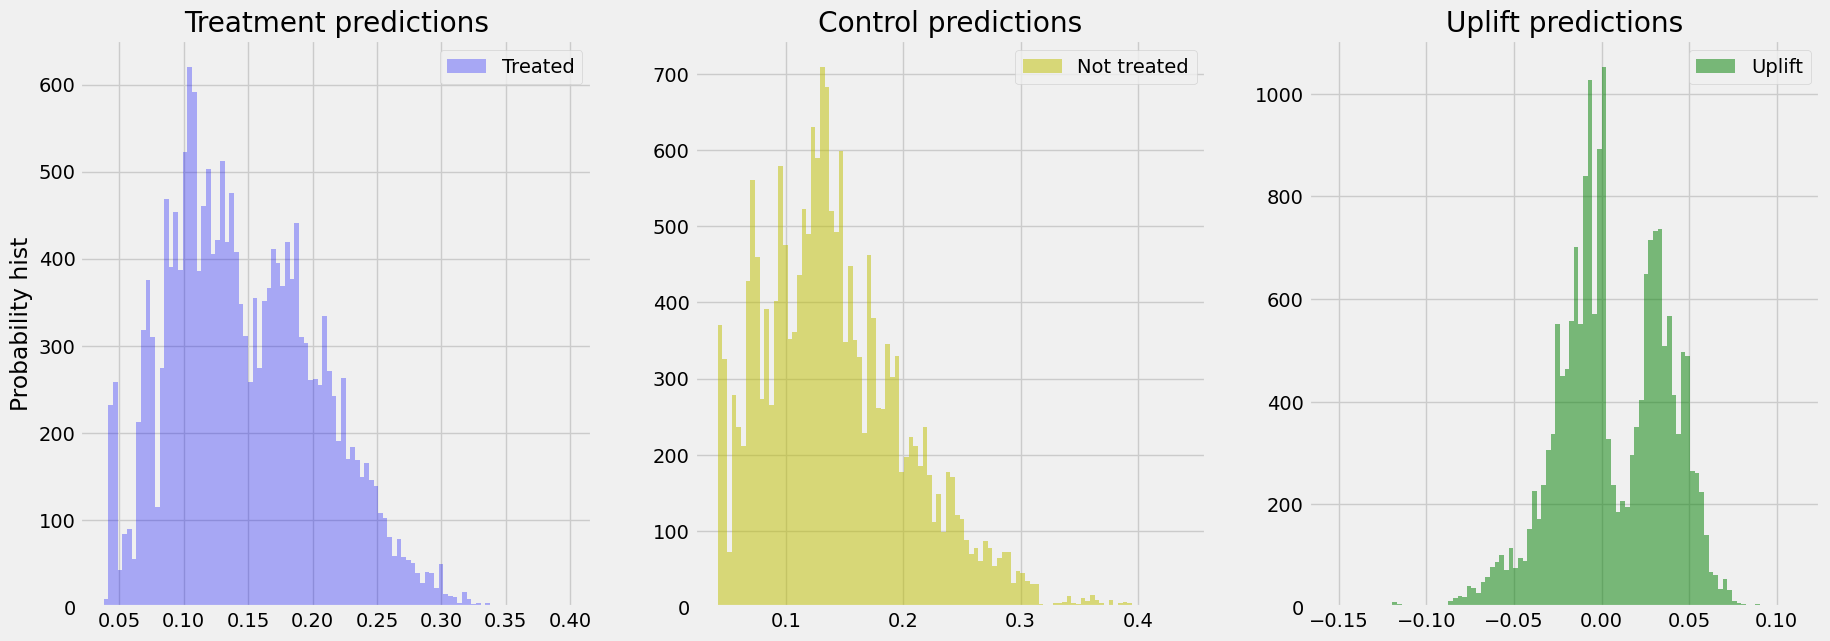

In [6]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [7]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.406056
1,recency,14.043279
2,zip_code,12.711363
3,used_bogo,12.439848
4,channel,11.293378
5,used_discount,11.145916
6,history,10.173658
7,treatment,7.786501


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [8]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

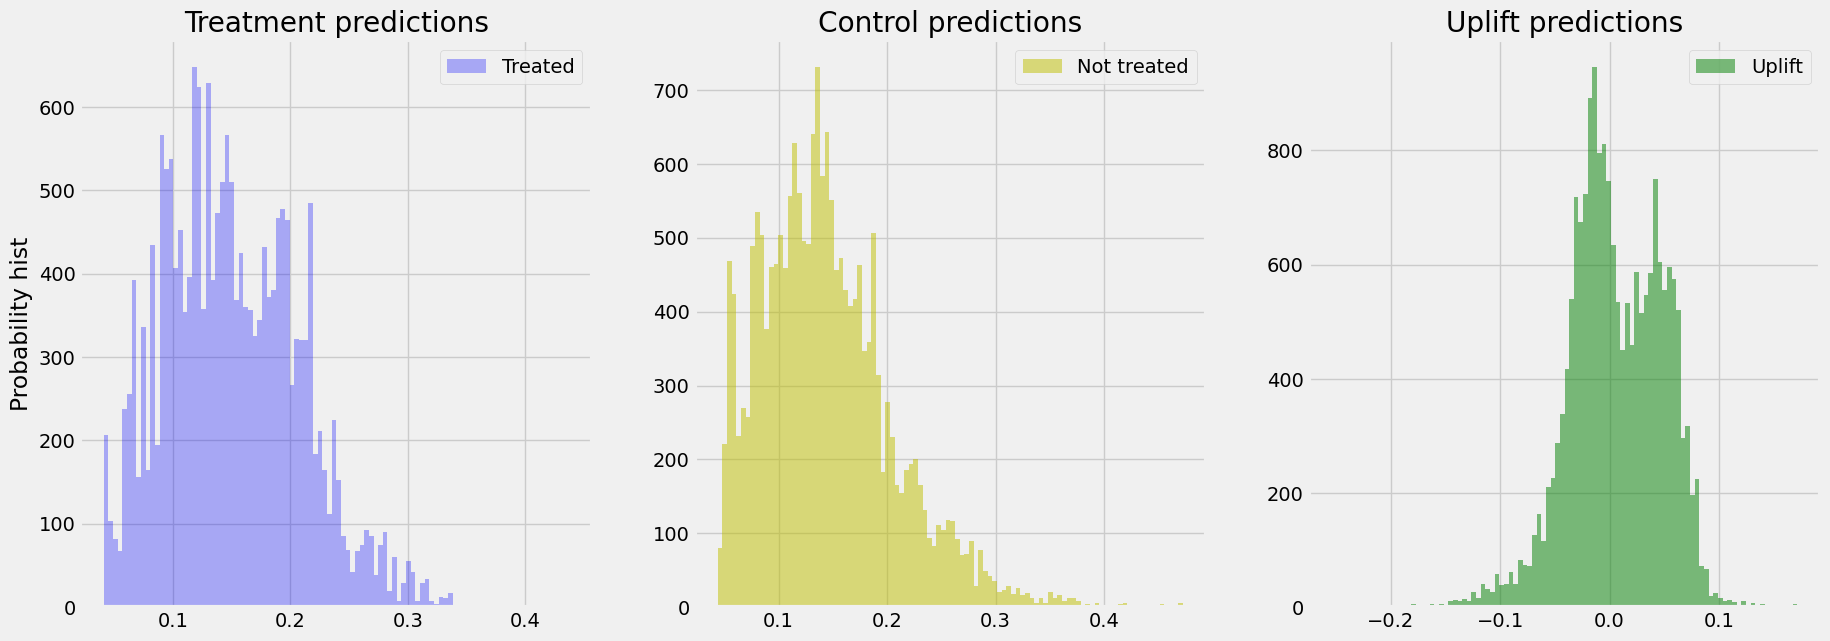

In [9]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [10]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.038037
2,TwoModels,0.034866
1,ClassTransformation,0.015566


#### Вариант с деревом решений

In [12]:
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9656,7,434.35,1,0,Urban,1,Web
63037,1,376.59,1,0,Surburban,0,Multichannel
31405,3,140.34,0,1,Urban,1,Phone
58088,3,150.76,0,1,Surburban,0,Web
44344,2,67.97,1,0,Surburban,1,Phone
...,...,...,...,...,...,...,...
62570,3,276.21,0,1,Urban,0,Phone
38158,4,43.49,0,1,Urban,0,Phone
860,8,492.53,1,1,Rural,1,Phone
15795,5,72.28,1,0,Urban,1,Web


In [28]:
X_train_tree = pd.concat([X_train.drop(['zip_code', 'channel'], axis=1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'), 
                          pd.get_dummies(X_train['channel'], prefix='channel')
                         ], axis=1)

features = [col for col in X_train_tree]
features

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

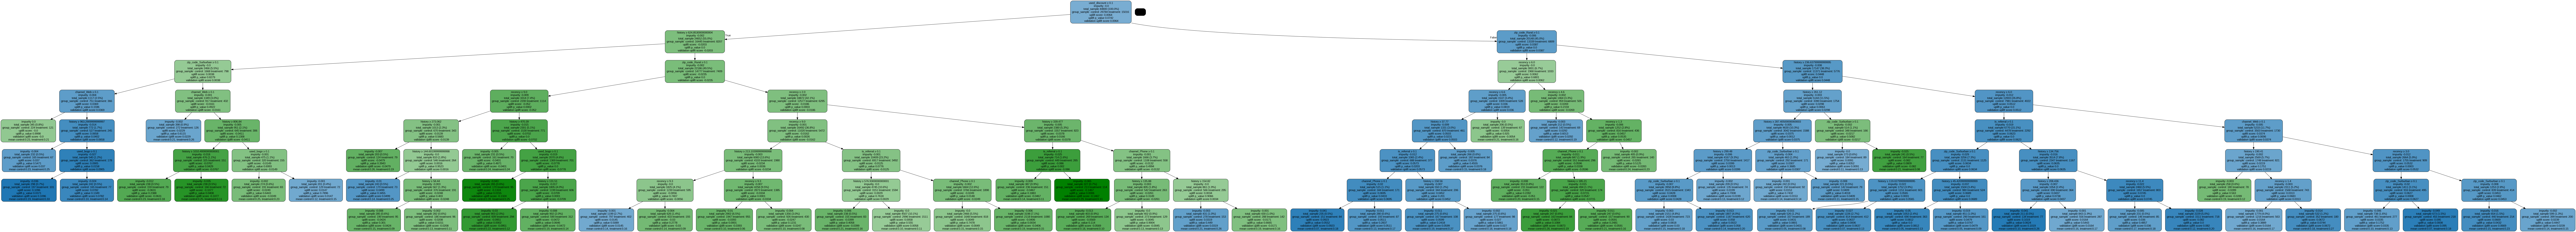

In [33]:
uplift_model = UpliftTreeClassifier(max_depth=8, 
                                    min_samples_leaf=200, 
                                    min_samples_treatment=50,
                                    n_reg=100, 
                                    evaluationFunction='KL', 
                                    control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())